# Can weather conditions forecast sunset prettiness?

**Purpose:** This notebook explores whether meteorological conditions can predict how pretty a sunset will be.

**Applications:** A working predictive model could harness weather forecast data to create a 'sunset prettiness forecast,' helping photographers identify the best evenings to shoot.

In [1]:
%matplotlib notebook

import sqlite3
import numpy as np
import pandas as pd
import hypertools as hyp
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from datetime import datetime
import plotly_express as px

/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/hypertools/plot/__init__.py:10: UserWarning: Could not switch backend to TkAgg.  This may impact performance of the plotting functions.
  warnings.warn('Could not switch backend to TkAgg.  This may impact performance of the plotting functions.')


**Data:** The model is trained on historical data (each night from ~2013-2019) from several cities (Vancouver, Seattle, Portland, San Francisco, Los Angeles, New York, Boston, and Dallas). Approximately 17,000 sunsets are represented. Meteorological data have been pulled from the excellent [Dark Sky API](https://darksky.net/dev). Sunset prettiness is approximated via the number of photos uploaded to Flickr of a given sunset.

In [2]:
# Pull together the two SQLite files
dbs = ["data.sqlite", "new_data.sqlite"]
weathers, flickrs, comps = [], [], []
for db in dbs:
    cnx = sqlite3.connect(db)
    weather = pd.read_sql_query("SELECT * FROM darkSky", cnx)
    flickr = pd.read_sql_query("SELECT * FROM flickr", cnx)
    # Relate weather and Flickr data
    comp = weather.set_index("sunset").sort_index().reset_index(drop = True).drop(columns = ["id", "nearestStorm"])
    comp.index.name = "sunset"
    # Count up Flickr photos
    flickrCounts = []
    for sunset in comp.index.values:
        count = flickr[flickr["sunset"] == sunset].shape[0]
        flickrCounts.append(count)
    comp["flickrCount"] = flickrCounts
    # Prepare to tie everything together
    weathers.append(weather)
    flickrs.append(flickr)
    comps.append(comp)

In [3]:
# Actually tie everything together
master = pd.concat(comps, ignore_index = True, verify_integrity = True)
# Drop duplicates / NANs; do some sorting
master.drop_duplicates(subset = ["timestamp", "geobase"], inplace = True)
master.dropna(axis = 0, subset = ["flickrCount"], inplace = True)
master.sort_values(by = ["geobase", "timestamp"], inplace = True)
# Compute a moving average for Flickr photos and a relative flickrScore instead of an absolute count
# (note: specific to each city)
flickrAvgs = pd.Series()
master["flickrAvg"] = np.nan
for geobase in master["geobase"].unique():
    theseAvgs = master[master["geobase"] == geobase][["timestamp", "flickrCount"]].rolling(365, on = "timestamp", min_periods = 1).mean()['flickrCount']
    flickrAvgs = flickrAvgs.append(theseAvgs)
master["flickrAvg"] = flickrAvgs
master["flickrScore"] = master["flickrCount"] / master["flickrAvg"]
# Drop some outliers
master = master[master["flickrScore"] > 0]
master = master[master["flickrScore"] < 30]
# master = master[master["geobase"].isin(["vancouver", "seattle", "portland"])]
master.reset_index(inplace = True) # Do not remove! Not sure why it's needed, but it is.

## Visualizing Flickr Scores

First, a simple histogram:

<IPython.core.display.Javascript object>


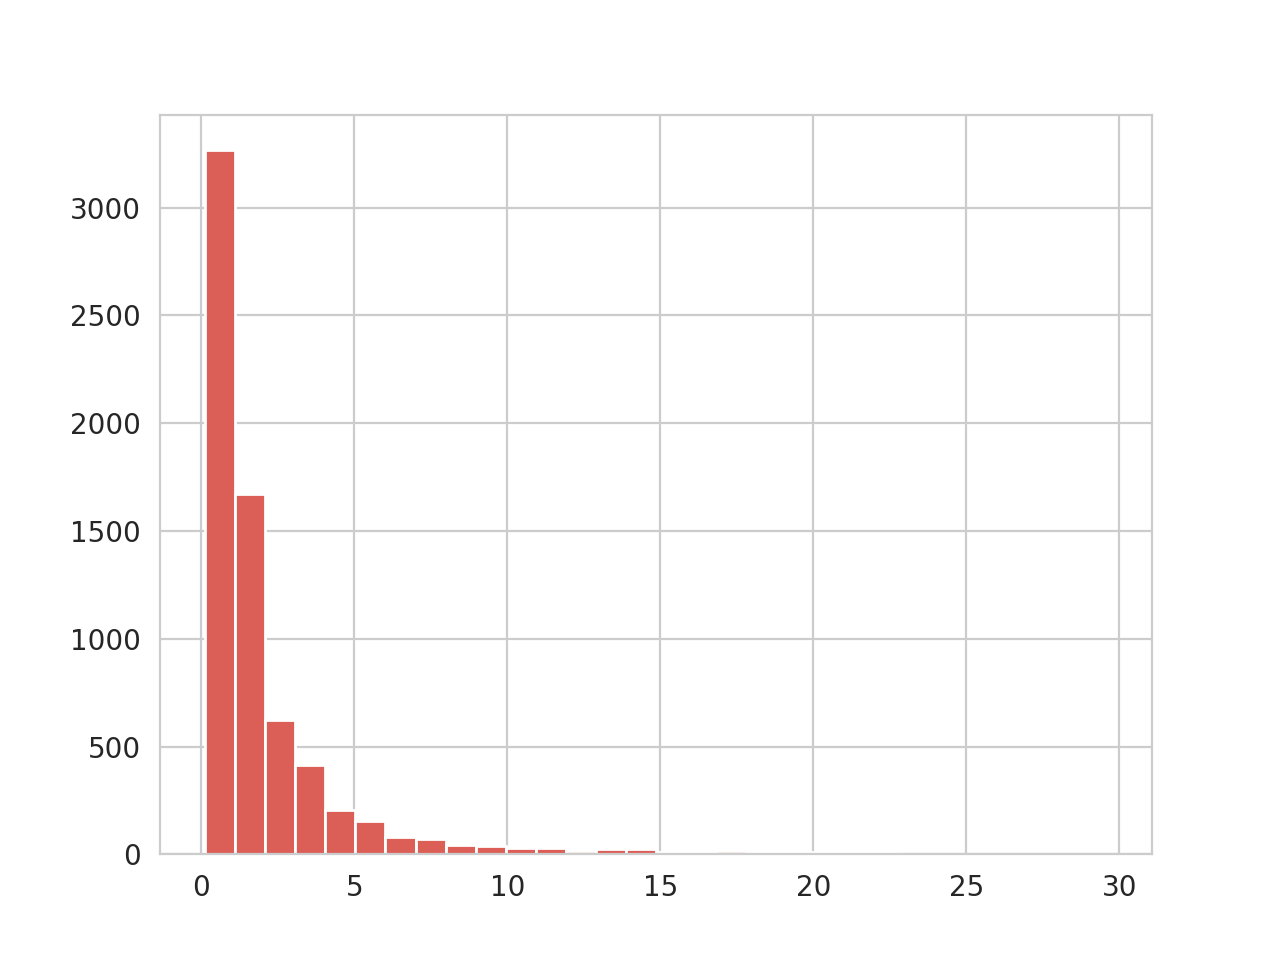

(array([3.265e+03, 1.672e+03, 6.250e+02, 4.150e+02, 2.080e+02, 1.530e+02,
        8.000e+01, 7.200e+01, 4.500e+01, 4.100e+01, 3.000e+01, 3.100e+01,
        1.600e+01, 2.600e+01, 2.300e+01, 9.000e+00, 1.100e+01, 1.400e+01,
        9.000e+00, 6.000e+00, 1.100e+01, 7.000e+00, 5.000e+00, 3.000e+00,
        2.000e+00, 3.000e+00, 4.000e+00, 4.000e+00, 1.000e+00, 4.000e+00]),
 array([ 0.12252434,  1.10492668,  2.08732902,  3.06973136,  4.0521337 ,
         5.03453605,  6.01693839,  6.99934073,  7.98174307,  8.96414541,
         9.94654776, 10.9289501 , 11.91135244, 12.89375478, 13.87615712,
        14.85855947, 15.84096181, 16.82336415, 17.80576649, 18.78816883,
        19.77057118, 20.75297352, 21.73537586, 22.7177782 , 23.70018054,
        24.68258288, 25.66498523, 26.64738757, 27.62978991, 28.61219225,
        29.59459459]),
 <a list of 30 Patch objects>)

In [15]:
# Visualize the overall distribution of flickrScore
%matplotlib notebook
plt.hist(master["flickrScore"], bins = 30)

And an animated bar plot of each city:

In [16]:
# Reshape the data into a form that Plotly Express can animate
forAnim = pd.DataFrame(columns = ["city", "date", "flickrScore"])
for geobase in master["geobase"].unique():
    for index, row in master[master["geobase"] == geobase].iterrows():
        day = datetime.utcfromtimestamp(row["timestamp"]).strftime("%Y-%m-%d")
        forAnim = forAnim.append({"city": geobase, "date": day, "flickrScore": row["flickrScore"]}, ignore_index = True)
# Animate!
%matplotlib notebook
px.bar(forAnim, x = "city", y = "flickrScore", animation_frame = "date")

## Looking for Patterns in the Data

First, a simple correlation matrix:

In [6]:
master.corr()

index  timestamp  precipIntensity  precipProb      temp  \
index            1.000000   0.197999         0.016078    0.072614  0.018626   
timestamp        0.197999   1.000000         0.007423    0.075738 -0.015854   
precipIntensity  0.016078   0.007423         1.000000    0.719885 -0.108809   
precipProb       0.072614   0.075738         0.719885    1.000000 -0.202704   
temp             0.018626  -0.015854        -0.108809   -0.202704  1.000000   
dewPoint        -0.009770  -0.017789         0.048382    0.031508  0.777475   
windSpeed       -0.464302  -0.168449         0.087157    0.052301 -0.111776   
cloudCover       0.383421   0.218828         0.306685    0.502099 -0.334455   
humidity        -0.048538   0.007467         0.292783    0.427767 -0.277213   
pressure        -0.048067   0.011618        -0.195217   -0.245430 -0.250629   
visibility      -0.048689  -0.057453        -0.379506   -0.443689  0.193406   
ozone            0.347004   0.413273         0.265240    0.260008 -0.497004   
flickrCount     -0.191919  -0.172694        -0.014880   -0.048436  0.031326   
flickrAvg       -0.552733  -0.370479         0.001453   -0.071584 -0.030879   
flickrScore      0.195645   0.077939        -0.005997    0.003028  0.103364   

                 dewPoint  windSpeed  cloudCover  humidity  pressure  \
index           -0.009770  -0.464302    0.383421 -0.048538 -0.048067   
timestamp       -0.017789  -0.168449    0.218828  0.007467  0.011618   
precipIntensity  0.048382   0.087157    0.306685  0.292783 -0.195217   
precipProb       0.031508   0.052301    0.502099  0.427767 -0.245430   
temp             0.777475  -0.111776   -0.334455 -0.277213 -0.250629   
dewPoint         1.000000  -0.134988    0.005380  0.368630 -0.297503   
windSpeed       -0.134988   1.000000   -0.195605 -0.043100 -0.146895   
cloudCover       0.005380  -0.195605    1.000000  0.561977 -0.146505   
humidity         0.368630  -0.043100    0.561977  1.000000 -0.111345   
pressure        -0.297503  -0.146895   -0.146505 -0.111345  1.000000   
visibility      -0.000536   0.073533   -0.371759 -0.355957  0.083059   
ozone           -0.476382  -0.236107    0.460493  0.000969  0.085933   
flickrCount      0.034670   0.093750   -0.137896  0.011047  0.031113   
flickrAvg        0.026753   0.326294   -0.325858  0.081599 -0.023814   
flickrScore      0.082344  -0.132841    0.052318 -0.033216  0.011548   

                 visibility     ozone  flickrCount  flickrAvg  flickrScore  
index             -0.048689  0.347004    -0.191919  -0.552733     0.195645  
timestamp         -0.057453  0.413273    -0.172694  -0.370479     0.077939  
precipIntensity   -0.379506  0.265240    -0.014880   0.001453    -0.005997  
precipProb        -0.443689  0.260008    -0.048436  -0.071584     0.003028  
temp               0.193406 -0.497004     0.031326  -0.030879     0.103364  
dewPoint          -0.000536 -0.476382     0.034670   0.026753     0.082344  
windSpeed          0.073533 -0.236107     0.093750   0.326294    -0.132841  
cloudCover        -0.371759  0.460493    -0.137896  -0.325858     0.052318  
humidity          -0.355957  0.000969     0.011047   0.081599    -0.033216  
pressure           0.083059  0.085933     0.031113  -0.023814     0.011548  
visibility         1.000000 -0.191490     0.030423   0.116393    -0.069064  
ozone             -0.191490  1.000000    -0.013398  -0.413021     0.211137  
flickrCount        0.030423 -0.013398     1.000000   0.274836     0.397104  
flickrAvg          0.116393 -0.413021     0.274836   1.000000    -0.343998  
flickrScore       -0.069064  0.211137     0.397104  -0.343998     1.000000

And a HyperTools plot to look for some structure in the weather data (Flickr data removed)

/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/hypertools/tools/df2mat.py:38: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/hypertools/tools/format_data.py:141: UserWarning:

Missing data: Inexact solution computed with PPCA (see https://github.com/allentran/pca-magic for details)



<IPython.core.display.Javascript object>


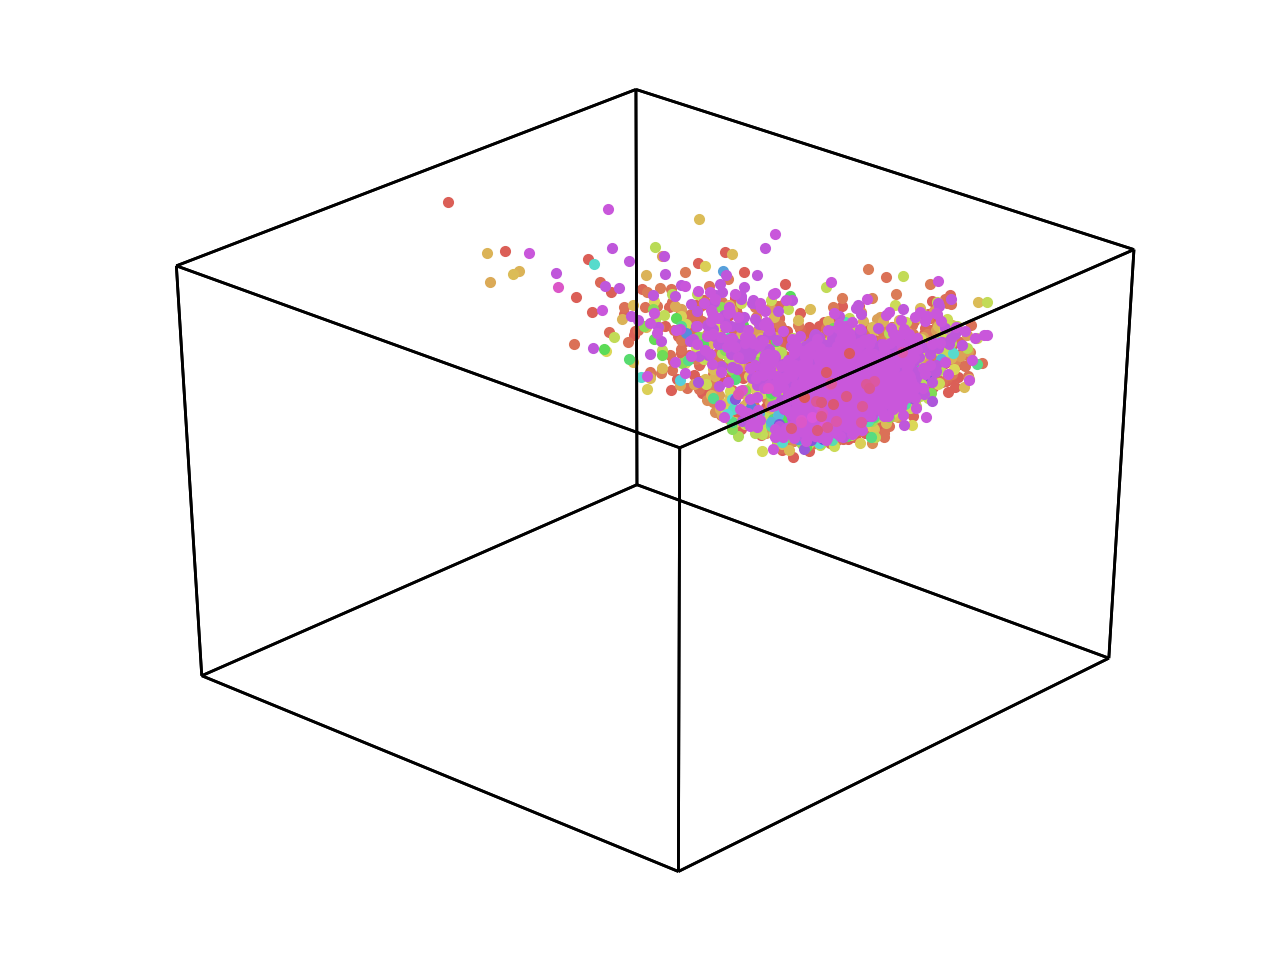

In [20]:
%matplotlib notebook
hyp.plot(master.drop(columns = ["index", "timestamp", "geobase", "flickrCount", "flickrAvg", "flickrScore"]), ".", hue = master["flickrScore"])

## Trying to Make Predictions

Can we train a predictive model to predict Flickr scores based on weather data?

In [8]:
def makeModel(data):
    # Use 75% of the data to train and 25% to test
    testFrac = 0.25
    # Repeat five times, because model performance varies a bit
    for i in list(range(5)):
        # Drop everything that isn't weather data
        reducedData = pd.DataFrame(hyp.reduce(data.drop(columns = ["index", "timestamp", "geobase", "flickrCount", "flickrAvg", "flickrScore"]), ndims=4, reduce='UMAP'))
        # Split test and train data
        testIn = pd.DataFrame(reducedData.sample(frac = testFrac))
        trainIn = pd.DataFrame(reducedData.drop(testIn.index))
        testOut = pd.DataFrame(data.loc[testIn.index]["flickrScore"])
        trainOut = pd.DataFrame(data.loc[trainIn.index]["flickrScore"])
        # Drop nulls
        testDrop = testOut[testOut.isnull().any(1)].index.values
        trainDrop = trainOut[trainOut.isnull().any(1)].index.values
        testIn.drop(testDrop, inplace = True)
        testOut.drop(testDrop, inplace = True)
        trainIn.drop(trainDrop, inplace = True)
        trainOut.drop(trainDrop, inplace = True)
        # Build and train the model
        model = MLPRegressor(solver = "lbfgs", alpha = 1e-5, hidden_layer_sizes = (10, 5, 3, 5, 10)).fit(trainIn, trainOut["flickrScore"].values)
        # Test the model and print out the score
        print(model.score(testIn, testOut["flickrScore"].values))

In [9]:
# Try the model with the real data
makeModel(master)

/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/hypertools/tools/df2mat.py:38: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/hypertools/tools/format_data.py:141: UserWarning:

Missing data: Inexact solution computed with PPCA (see https://github.com/allentran/pca-magic for details)



0.021748411074404506
0.050090667251100784
0.000655533542455955
0.004834208874601842
0.004560766217162837


The model didn't work very well, so let's try a reality check: make a fake Flickr score based directly on weather data and see if we can predict that.

In [10]:
# Make the fake data
fakeData = master.copy()
fakeData["flickrScore"] = fakeData["precipProb"] ** fakeData["visibility"]

In [11]:
# Check the correlation matrix to make sure the relationships we expect exist

/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/hypertools/tools/df2mat.py:38: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/hypertools/tools/format_data.py:141: UserWarning:

Missing data: Inexact solution computed with PPCA (see https://github.com/allentran/pca-magic for details)



<IPython.core.display.Javascript object>


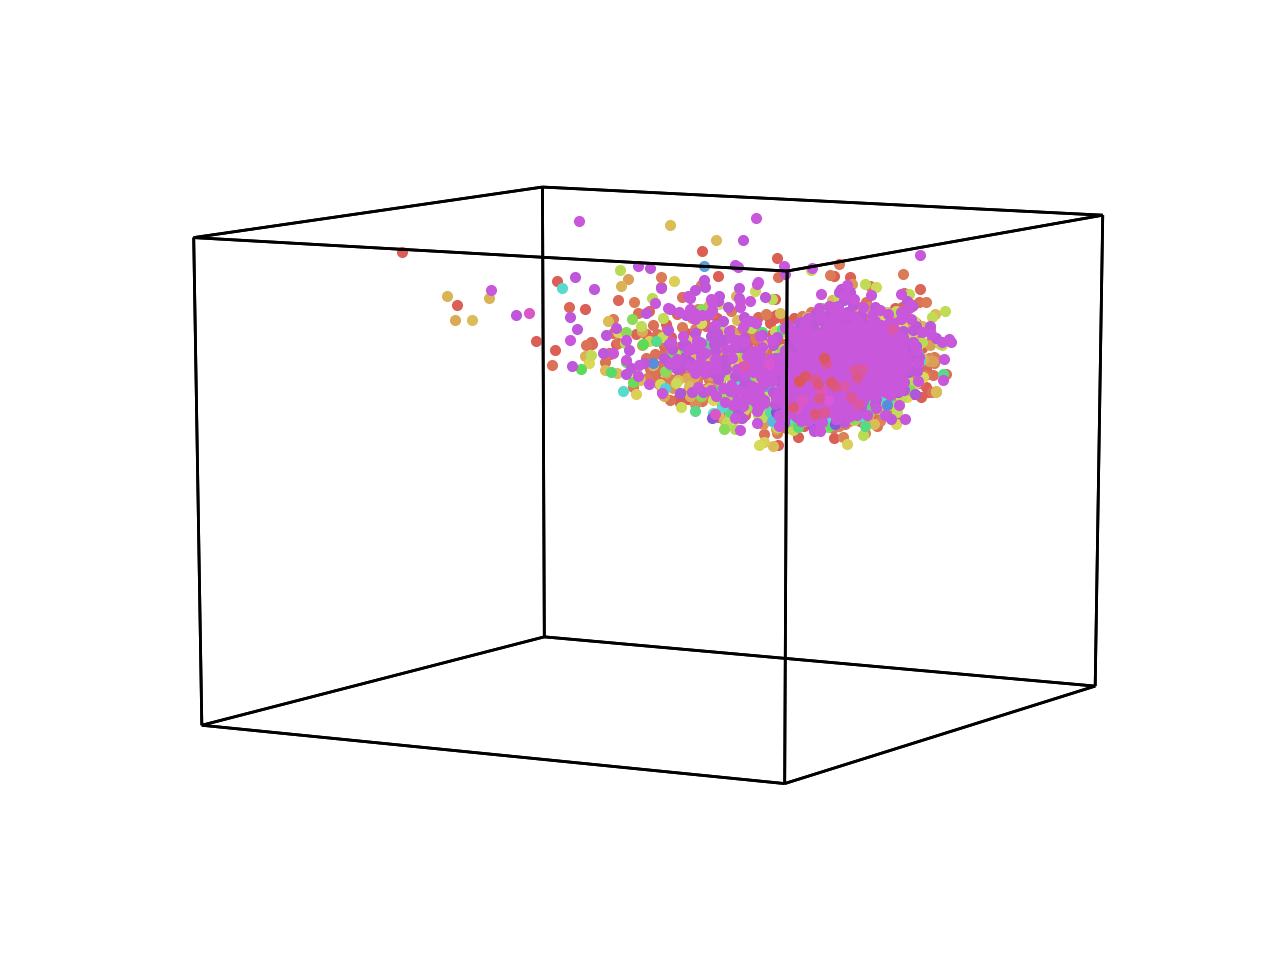

In [18]:
# Use a HyperTools plot to look for structure
%matplotlib notebook
hyp.plot(fakeData.drop(columns = ["index", "timestamp", "geobase", "flickrCount", "flickrAvg", "flickrScore"]), ".", hue = master["flickrScore"])

In [13]:
# Try training the model on the fake data and see if it's predictive
makeModel(fakeData)

0.8071854735100848
0.8810533048836575
0.8524037078368217
-0.00041487174520637993
0.7648628367863118


And, it works. Seems like there's nothing wrong with this setup in theory, so we can conclude that the weather data we have just isn't terribly useful in predicting Flickr popularity. No story here, unfortunately.